<span style="color: blue;font-weight: bold; font-size: 40px;">ISBSG Data Analysis & Regression </span>

In [1]:
# # ISBSG Data Analysis and Regression Modeling
# 
# This notebook performs data cleaning, preprocessing, and regression modeling on the ISBSG dataset.

# ## Setup and Environment Configuration

# Install required packages (uncomment if needed)
# !pip install -r requirements.txt

In [35]:
# Import basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re

Cell executed at: 2025-05-17 12:33:05.366613


<a id = 'Index:'></a>

# Table of Content

In this notebook you will apply xxxxxxx


- [Part 1](#part1)- Data Loading and Initial Exploration
- [Part 2](#part2)- Data Cleaning and Preprocessing
- [Part 3](#part3)- Data Profiling
- [Part 4](#part4)- Module Building with PyCaret
- [Part 5](#part5)- Model Preparation
- [Part 6](#part6)- Baseline Modeling and Evaluation
- [Part 7](#part7)- Advanced Modeling and Hyperparameter Tuning
- [Part 8](#part8)- Model Comparison and Selection
- [Part 9](#part9)- End


In [36]:
# Configure timestamp callback for Jupyter cells
from IPython import get_ipython

def setup_timestamp_callback():
    """Setup a timestamp callback for Jupyter cells without clearing existing callbacks."""
    ip = get_ipython()
    if ip is not None:
        # Define timestamp function
        def print_timestamp(*args, **kwargs):
            """Print timestamp after cell execution."""
            print(f"Cell executed at: {datetime.now()}")
        
        # Check if our callback is already registered
        callbacks = ip.events.callbacks.get('post_run_cell', [])
        for cb in callbacks:
            if hasattr(cb, '__name__') and cb.__name__ == 'print_timestamp':
                # Already registered
                return
                
        # Register new callback if not already present
        ip.events.register('post_run_cell', print_timestamp)
        print("Timestamp printing activated.")
    else:
        print("Not running in IPython/Jupyter environment.")

Cell executed at: 2025-05-17 12:33:06.320449


In [37]:
# Setup timestamp callback
setup_timestamp_callback()

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

Cell executed at: 2025-05-17 12:33:07.086946


[Back to top](#Index:)

<a id='part1'></a>

# Part 1 -Data Loading and Initial Exploration

This section is dedicated to loading the dataset, performing initial data exploration such as viewing the first few rows, and summarizing the dataset's characteristics, including missing values and basic statistical measures.

In [38]:
# Load the data
print("Loading data...")
df = pd.read_csv("data/ISBSG2016R1.1-Formatted4CSVAgileOnly_cleaned.csv")


Loading data...
Cell executed at: 2025-05-17 12:33:08.749040


In [39]:
# Clean column names function
def clean_column_names(columns):
    cleaned_cols = []
    for col in columns:
        # First replace ampersands with _&_ to match PyCaret's transformation
        col_clean = col.replace(' & ', '_&_')
        # Then remove any remaining special chars
        col_clean = re.sub(r'[^\w\s&]', '', col_clean)
        # Finally replace spaces with underscores
        col_clean = col_clean.replace(' ', '_')
        cleaned_cols.append(col_clean)
    return cleaned_cols

# Clean column names
original_columns = df.columns.tolist()  # Save original column names for reference
df.columns = clean_column_names(df.columns)

Cell executed at: 2025-05-17 12:33:10.160667


In [40]:
# Create a mapping from original to cleaned column names
column_mapping = dict(zip(original_columns, df.columns))
print("\nColumn name mapping (original -> cleaned):")
for orig, clean in column_mapping.items():
    if orig != clean:  # Only show columns that changed
        print(f"  '{orig}' -> '{clean}'")



Column name mapping (original -> cleaned):
Cell executed at: 2025-05-17 12:33:12.518249


In [41]:
# Display basic information
print(f"Dataset shape: {df.shape}")
print("\nFirst 5 rows:")
print(df.head())


Dataset shape: (85, 51)

First 5 rows:
   isbsg_project_id external_eef_data_quality_rating  \
0             10279                                b   
1             10317                                b   
2             10572                                b   
3             11278                                a   
4             11497                                b   

   project_prf_year_of_project external_eef_industry_sector  \
0                         2013                      banking   
1                         2015                   government   
2                         2014                   government   
3                         2010             service industry   
4                         2012                      banking   

                      external_eef_organisation_type  \
0  banking; communications; education institution...   
1                                         government   
2                                         government   
3                    

In [42]:
# Create a function to get comprehensive data summary
def get_data_summary(df, n_unique_samples=5):
    """
    Generate a comprehensive summary of the dataframe.
    
    Args:
        df: Pandas DataFrame
        n_unique_samples: Number of unique values to show as sample
        
    Returns:
        DataFrame with summary information
    """
    # Summary dataframe with basic info
    summary = pd.DataFrame({
        'Feature': df.columns,
        'data_type': df.dtypes.values,
        'Null_number': df.isnull().sum().values,
        'Null_pct': (df.isnull().mean() * 100).values,
        'Unique_counts': df.nunique().values,
        'unique_samples': [list(df[col].dropna().unique()[:n_unique_samples]) for col in df.columns]
    })
    
    return summary

# Generate and display data summary
summary_df = get_data_summary(df)
print("\nData Summary (first 10 columns):")
print(summary_df.head(10))



Data Summary (first 10 columns):
                            Feature data_type  Null_number   Null_pct  \
0                  isbsg_project_id     int64            0   0.000000   
1  external_eef_data_quality_rating    object            0   0.000000   
2       project_prf_year_of_project     int64            0   0.000000   
3      external_eef_industry_sector    object            1   1.176471   
4    external_eef_organisation_type    object            0   0.000000   
5     project_prf_application_group    object            5   5.882353   
6      project_prf_application_type    object            0   0.000000   
7      project_prf_development_type    object            0   0.000000   
8      tech_tf_development_platform    object           15  17.647059   
9             tech_tf_language_type    object            0   0.000000   

   Unique_counts                                     unique_samples  
0             84                [10279, 10317, 10572, 11278, 11497]  
1              2      

In [43]:
# Display descriptive statistics for numeric columns
desc_stats = df.describe().T
print("\nDescriptive Statistics (first 5 rows):")
print(desc_stats.head())


Descriptive Statistics (first 5 rows):
                                            count          mean          std  \
isbsg_project_id                             85.0  21197.176471  6796.647824   
project_prf_year_of_project                  85.0   2011.376471     2.132383   
project_prf_functional_size                  84.0    188.464286   316.182327   
project_prf_normalised_work_effort_level_1   85.0   2310.494118  7041.106335   
project_prf_normalised_work_effort           85.0   2590.352941  8670.472883   

                                                min       25%      50%  \
isbsg_project_id                            10279.0  14928.00  20465.0   
project_prf_year_of_project                  2005.0   2010.00   2012.0   
project_prf_functional_size                     2.0     23.75     83.5   
project_prf_normalised_work_effort_level_1      6.0     74.00    489.0   
project_prf_normalised_work_effort              6.0     82.00    489.0   

                                  

In [44]:
# Identify target column
target_col = 'project_prf_normalised_work_effort'
print(f"\nTarget variable: '{target_col}'")


Target variable: 'project_prf_normalised_work_effort'
Cell executed at: 2025-05-17 12:33:20.019612


[Back to top](#Index:)

<a id='part2'></a>

# Part 2 - Data Cleaning and Preprocessing

Here, data cleaning tasks like handling missing values and providing a detailed summary of each feature, including its type, number of unique values, and a preview of unique values, are performed.

In [45]:
# Analyse missing values
print("\nAnalysing missing values...")
missing_pct = df.isnull().mean() * 100
missing_sorted = missing_pct.sort_values(ascending=False)
print("Top 10 columns with highest missing percentages:")
print(missing_sorted.head(10))


Analysing missing values...
Top 10 columns with highest missing percentages:
people_prf_it_experience_great_than_3_yr         100.000000
people_prf_it_experience_1_to_3_yr               100.000000
people_prf_it_experience_less_than_1_yr          100.000000
people_prf_project_user_involvement              100.000000
tech_tf_type_of_server                           100.000000
process_pmf_prototyping_used                      95.294118
people_prf_ba_team_experience_less_than_1_yr      84.705882
project_prf_case_tool_used                        83.529412
people_prf_it_experience_great_than_9_yr          82.352941
people_prf_ba_team_experience_great_than_3_yr     82.352941
dtype: float64
Cell executed at: 2025-05-17 12:33:23.560540


In [46]:
# Identify columns with high missing values (>70%)
high_missing_cols = missing_pct[missing_pct > 70].index.tolist()
print(f"\nColumns with >70% missing values ({len(high_missing_cols)} columns):")
for col in high_missing_cols[:5]:  # Show first 5
    print(f"  - {col}: {missing_pct[col]:.2f}% missing")
if len(high_missing_cols) > 5:
    print(f"  - ... and {len(high_missing_cols) - 5} more columns")


Columns with >70% missing values (16 columns):
  - project_prf_case_tool_used: 83.53% missing
  - process_pmf_prototyping_used: 95.29% missing
  - tech_tf_client_roles: 70.59% missing
  - tech_tf_type_of_server: 100.00% missing
  - people_prf_project_user_involvement: 100.00% missing
  - ... and 11 more columns
Cell executed at: 2025-05-17 12:33:28.608616


In [47]:
# Create a clean dataframe by dropping high-missing columns
df_clean = df.drop(columns=high_missing_cols)
print(f"\nData shape after dropping high-missing columns: {df_clean.shape}")
print(f"\nHigh missing columns got dropped are: {high_missing_cols}")

# Numerical columns
num_cols = df.select_dtypes(include=['number']).columns.tolist()
print("\nNumerical columns:")
print(num_cols)

# Categorical columns (object or category dtype)
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
print("\nCategorical columns:")
print(cat_cols)




Data shape after dropping high-missing columns: (85, 35)

High missing columns got dropped are: ['project_prf_case_tool_used', 'process_pmf_prototyping_used', 'tech_tf_client_roles', 'tech_tf_type_of_server', 'people_prf_project_user_involvement', 'people_prf_ba_team_experience_less_than_1_yr', 'people_prf_ba_team_experience_1_to_3_yr', 'people_prf_ba_team_experience_great_than_3_yr', 'people_prf_it_experience_less_than_1_yr', 'people_prf_it_experience_1_to_3_yr', 'people_prf_it_experience_great_than_3_yr', 'people_prf_it_experience_less_than_3_yr', 'people_prf_it_experience_3_to_9_yr', 'people_prf_it_experience_great_than_9_yr', 'people_prf_project_manage_experience', 'project_prf_currency_multiple']

Numerical columns:
['isbsg_project_id', 'project_prf_year_of_project', 'project_prf_functional_size', 'project_prf_normalised_work_effort_level_1', 'project_prf_normalised_work_effort', 'project_prf_normalised_level_1_pdr_ufp', 'project_prf_normalised_pdr_ufp', 'project_prf_defect_densi

In [48]:
# Handle remaining missing values
print("\nHandling remaining missing values...")


Handling remaining missing values...
Cell executed at: 2025-05-17 12:33:31.070323


In [49]:
# Fill missing values in categorical columns with "Missing"
cat_cols = df_clean.select_dtypes(include=['object', 'category']).columns
for col in cat_cols:
    df_clean[col].fillna('Missing', inplace=True)

Cell executed at: 2025-05-17 12:33:33.326789


In [50]:
# Check remaining missing values
remaining_missing = df_clean.isnull().sum()
remaining_missing_count = sum(remaining_missing > 0)
print(f"\nColumns with remaining missing values: {remaining_missing_count}")
if remaining_missing_count > 0:
    print("Top columns with missing values:")
    print(remaining_missing[remaining_missing > 0].sort_values(ascending=False).head())


Columns with remaining missing values: 12
Top columns with missing values:
project_prf_total_project_cost       57
project_prf_defect_density           55
people_prf_project_manage_changes    55
people_prf_personnel_changes         55
tech_tf_tools_used                   31
dtype: int64
Cell executed at: 2025-05-17 12:33:33.961086


In [51]:
# Verify target variable
print(f"\nTarget variable '{target_col}' summary:")
print(f"Unique values: {df_clean[target_col].nunique()}")
print(f"Missing values: {df_clean[target_col].isnull().sum()}")
print(f"Top value counts:")
print(df_clean[target_col].value_counts().head())



Target variable 'project_prf_normalised_work_effort' summary:
Unique values: 78
Missing values: 0
Top value counts:
project_prf_normalised_work_effort
47      4
225     2
1105    2
125     2
51      2
Name: count, dtype: int64
Cell executed at: 2025-05-17 12:33:35.366074


In [52]:
# Check for infinite values
inf_check = np.isinf(df_clean.select_dtypes(include=[np.number])).sum().sum()
print(f"\nNumber of infinite values: {inf_check}")


Number of infinite values: 0
Cell executed at: 2025-05-17 12:33:37.215156


In [53]:
# Save cleaned data
df_clean.to_csv('data/cleaned_data.csv', index=False)
print("\nCleaned data saved to 'data/cleaned_data.csv'")



Cleaned data saved to 'data/cleaned_data.csv'
Cell executed at: 2025-05-17 12:33:40.128776


[Back to top](#Index:)

<a id='part3'></a>

# Part 3 - Feature Engineering and Selection

Involves creating or selecting specific features for the model based on insights from EDA, including handling categorical variables and reducing dimensionality if necessary.

In [54]:
# Identify categorical columns and check cardinality
print("\nCategorical columns and their cardinality:")
cat_cols = df_clean.select_dtypes(include=['object', 'category']).columns.tolist()
for col in cat_cols[:5]:  # Show first 5
    print(f"  {col}: {df_clean[col].nunique()} unique values")
if len(cat_cols) > 5:
    print(f"  ... and {len(cat_cols) - 5} more columns")


Categorical columns and their cardinality:
  external_eef_data_quality_rating: 2 unique values
  external_eef_industry_sector: 12 unique values
  external_eef_organisation_type: 25 unique values
  project_prf_application_group: 5 unique values
  project_prf_application_type: 32 unique values
  ... and 13 more columns
Cell executed at: 2025-05-17 12:33:43.103487


In [55]:
# One-hot encode categorical columns with low cardinality (<10 unique values)
low_card_cols = [col for col in cat_cols if df_clean[col].nunique() < 10]
print(f"\nApplying one-hot encoding to {len(low_card_cols)} low-cardinality columns:")
for col in low_card_cols[:5]:  # Show first 5
    print(f"  - {col}")
if len(low_card_cols) > 5:
    print(f"  - ... and {len(low_card_cols) - 5} more columns")



Applying one-hot encoding to 14 low-cardinality columns:
  - external_eef_data_quality_rating
  - project_prf_application_group
  - project_prf_development_type
  - tech_tf_development_platform
  - tech_tf_language_type
  - ... and 9 more columns
Cell executed at: 2025-05-17 12:33:44.353003


In [56]:
# Create encoded dataframe
df_encoded = pd.get_dummies(df_clean, columns=low_card_cols, drop_first=True)
print(f"\nData shape after one-hot encoding: {df_encoded.shape}")
print("\nAll column names:")
print(df_encoded.columns.tolist())



Data shape after one-hot encoding: (85, 73)

All column names:
['isbsg_project_id', 'project_prf_year_of_project', 'external_eef_industry_sector', 'external_eef_organisation_type', 'project_prf_application_type', 'project_prf_functional_size', 'project_prf_normalised_work_effort_level_1', 'project_prf_normalised_work_effort', 'project_prf_normalised_level_1_pdr_ufp', 'project_prf_normalised_pdr_ufp', 'project_prf_defect_density', 'project_prf_speed_of_delivery', 'project_prf_manpower_delivery_rate', 'project_prf_project_elapsed_time', 'project_prf_max_team_size', 'process_pmf_docs', 'tech_tf_server_roles', 'tech_tf_tools_used', 'people_prf_project_manage_changes', 'people_prf_personnel_changes', 'project_prf_total_project_cost', 'external_eef_data_quality_rating_b', 'project_prf_application_group_business application', 'project_prf_application_group_infrastructure software', 'project_prf_application_group_mathematically-intensive application', 'project_prf_application_group_real-time 

In [57]:
# MANUALLY fix the problematic column names BEFORE PyCaret setup

# Function to fix the column names and prevent duplicates
def fix_column_names_no_duplicates(df):
    """Fix column names that cause issues with PyCaret while preventing duplicates."""
    original_cols = df.columns.tolist()
    fixed_columns = []
    
    # Track columns to check for duplicates
    seen_columns = set()
    
    for col in original_cols:
        # Replace spaces with underscores
        fixed_col = col.replace(' ', '_')
        # Replace ampersands 
        fixed_col = fixed_col.replace('&', 'and')
        # Remove any other problematic characters
        fixed_col = ''.join(c if c.isalnum() or c == '_' else '_' for c in fixed_col)
        
        # Handle duplicates by appending a suffix
        base_col = fixed_col
        suffix = 1
        while fixed_col in seen_columns:
            fixed_col = f"{base_col}_{suffix}"
            suffix += 1
        
        seen_columns.add(fixed_col)
        fixed_columns.append(fixed_col)
    
    # Create a new DataFrame with fixed column names
    df_fixed = df.copy()
    df_fixed.columns = fixed_columns
    
    # Print statistics about the renaming
    n_changed = sum(1 for old, new in zip(original_cols, fixed_columns) if old != new)
    print(f"Changed {n_changed} column names.")
    
    # Check for duplicates in the new column names
    dup_check = [item for item, count in pd.Series(fixed_columns).value_counts().items() if count > 1]
    if dup_check:
        print(f"WARNING: Found {len(dup_check)} duplicate column names after fixing: {dup_check}")
    else:
        print("No duplicate column names in the fixed DataFrame.")
    
    return df_fixed

# Show some of the original column names to help diagnose issues
print("\nSample of original column names:")
for i, col in enumerate(df_encoded.columns[:15]):  # Show first 15 for diagnosis
    print(f"{i}: {col}")

# Apply the fix to your dataframe
print("\nFixing column names for PyCaret compatibility...")
df_fixed = fix_column_names_no_duplicates(df_encoded)

# Print some example fixed columns to verify
print("\nSample of fixed column names:")
for i, (old, new) in enumerate(zip(df_encoded.columns[:15], df_fixed.columns[:15])):
    print(f"Original: {old} -> Fixed: {new}")


Sample of original column names:
0: isbsg_project_id
1: project_prf_year_of_project
2: external_eef_industry_sector
3: external_eef_organisation_type
4: project_prf_application_type
5: project_prf_functional_size
6: project_prf_normalised_work_effort_level_1
7: project_prf_normalised_work_effort
8: project_prf_normalised_level_1_pdr_ufp
9: project_prf_normalised_pdr_ufp
10: project_prf_defect_density
11: project_prf_speed_of_delivery
12: project_prf_manpower_delivery_rate
13: project_prf_project_elapsed_time
14: project_prf_max_team_size

Fixing column names for PyCaret compatibility...
Changed 29 column names.
No duplicate column names in the fixed DataFrame.

Sample of fixed column names:
Original: isbsg_project_id -> Fixed: isbsg_project_id
Original: project_prf_year_of_project -> Fixed: project_prf_year_of_project
Original: external_eef_industry_sector -> Fixed: external_eef_industry_sector
Original: external_eef_organisation_type -> Fixed: external_eef_organisation_type
Original:

In [58]:
# Save this DataFrame with fixed column names
df_fixed.to_csv('data/fixed_columns_data.csv', index=False)
print(f"Saved data with fixed column names to 'data/fixed_columns_data.csv'")

Saved data with fixed column names to 'data/fixed_columns_data.csv'
Cell executed at: 2025-05-17 12:36:11.550142


In [59]:
# Create a diagnostic file with all column transformations
with open('column_transformations.txt', 'w') as f:
    f.write("Column name transformations:\n")
    f.write("--------------------------\n")
    for old, new in zip(df_encoded.columns, df_fixed.columns):
        f.write(f"{old} -> {new}\n")
print("Saved complete column transformations to 'column_transformations.txt'")

Saved complete column transformations to 'column_transformations.txt'
Cell executed at: 2025-05-17 12:36:13.381186


[Back to top](#Index:)

<a id='part4'></a>

# Part 4 - Data Profiling

xxx

In [60]:
# ## Data Profiling (Optional)

try:
    from ydata_profiling import ProfileReport
    
    print("\nGenerating data profile report...")
    profile = ProfileReport(df_clean, title="ISBSG Dataset Profiling Report", minimal=True)
    profile.to_file("data_profile.html")
    print("Data profile report saved to 'data_profile.html'")
except ImportError:
    print("\nSkipping data profiling (ydata_profiling not installed)")
    print("To install: pip install ydata-profiling")


Generating data profile report...


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


%|          | 0/35 [00:00<?, ?it/s]
100%|██████████| 35/35 [00:00<00:00, 107.56it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Data profile report saved to 'data_profile.html'
Cell executed at: 2025-05-17 12:37:18.750031


[Back to top](#Index:)

<a id='part5'></a>

# Part 5 - PyCaret setup

xxx

In [84]:
from pycaret.regression import setup, get_config
setup_results = setup(
    data=df,
    target=target_col,
    session_id=123,
    preprocess=True,
    # ...other options...
    verbose=False
)

Cell executed at: 2025-05-17 13:29:08.576013


[Back to top](#Index:)

<a id='part6'></a>

# Part 6 - Feature Correlation Analysis

xxx

In [86]:
# Feature correlation analysis
print("\nAnalyzing feature correlations...")
try:
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    import os
    from pycaret.regression import get_config
    
    # Create directory for plots
    os.makedirs('plots', exist_ok=True)
    
    # Get data from PyCaret
    X = get_config('X')
    
    # Ensure we're working with numeric data only
    X_numeric = X.select_dtypes(include=[np.number])
    
    # Get number of features
    n_features = X_numeric.shape[1]
    print(f"Analyzing correlations among {n_features} numeric features")
    
    # Calculate correlation matrix
    corr_matrix = X_numeric.corr()
    
    # Determine features with high correlation
    correlation_threshold = 0.7
    high_corr_pairs = []
    
    # Find highly correlated feature pairs
    for i in range(n_features):
        for j in range(i+1, n_features):
            if abs(corr_matrix.iloc[i, j]) > correlation_threshold:
                high_corr_pairs.append((
                    X_numeric.columns[i],
                    X_numeric.columns[j],
                    corr_matrix.iloc[i, j]
                ))
    
    # Plot correlation heatmap
    plt.figure(figsize=(14, 12))
    mask = np.triu(corr_matrix)
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    
    # If there are too many features, show only the ones with high correlation
    if n_features > 20:
        print(f"Large number of features detected ({n_features}). Creating filtered correlation matrix.")
        # Get list of features with high correlation
        high_corr_features = set()
        for feat1, feat2, _ in high_corr_pairs:
            high_corr_features.add(feat1)
            high_corr_features.add(feat2)
        
        # If there are high correlations, show only those features
        if high_corr_features:
            high_corr_features = list(high_corr_features)
            filtered_corr = corr_matrix.loc[high_corr_features, high_corr_features]
            
            # Plot filtered heatmap
            sns.heatmap(filtered_corr, mask=np.triu(filtered_corr), 
                       cmap=cmap, vmax=1, vmin=-1, center=0,
                       square=True, linewidths=.5, cbar_kws={"shrink": .5},
                       annot=True, fmt=".2f")
            plt.title('Correlation Heatmap (Filtered to Highly Correlated Features)')
        else:
            # No high correlations, show full matrix
            sns.heatmap(corr_matrix, mask=mask, 
                       cmap=cmap, vmax=1, vmin=-1, center=0,
                       square=True, linewidths=.5, cbar_kws={"shrink": .5})
            plt.title('Correlation Heatmap (All Features)')
    else:
        # For smaller feature sets, show the full correlation matrix
        sns.heatmap(corr_matrix, mask=mask, 
                   cmap=cmap, vmax=1, vmin=-1, center=0,
                   square=True, linewidths=.5, cbar_kws={"shrink": .5},
                   annot=True, fmt=".2f")
        plt.title('Correlation Heatmap (All Features)')
    
    plt.tight_layout()
    plt.savefig('plots/correlation_heatmap.png')
    plt.close()
    print("Correlation heatmap saved as plots/correlation_heatmap.png")
    
    # Calculate Variance Inflation Factor (VIF) if there are enough samples
    vif_data = None
    if X_numeric.shape[0] > X_numeric.shape[1]:
        try:
            from statsmodels.stats.outliers_influence import variance_inflation_factor
            
            # Calculate VIF for each feature
            vif_data = pd.DataFrame()
            vif_data["Feature"] = X_numeric.columns
            vif_data["VIF"] = [variance_inflation_factor(X_numeric.values, i) 
                              for i in range(X_numeric.shape[1])]
            
            # Sort by VIF value
            vif_data = vif_data.sort_values("VIF", ascending=False)
            
            # Plot VIF values
            plt.figure(figsize=(12, 8))
            plt.barh(vif_data["Feature"], vif_data["VIF"])
            plt.axvline(x=5, color='r', linestyle='--', label='VIF=5 (Moderate multicollinearity)')
            plt.axvline(x=10, color='darkred', linestyle='--', label='VIF=10 (High multicollinearity)')
            plt.xlabel('VIF Value')
            plt.title('Variance Inflation Factor (VIF) for Features')
            plt.legend()
            plt.tight_layout()
            plt.savefig('plots/vif_values.png')
            plt.close()
            print("VIF values plot saved as plots/vif_values.png")
        except Exception as vif_err:
            print(f"Could not calculate VIF: {vif_err}")
    else:
        print("Not enough samples to calculate VIF (need more samples than features)")
    
    # Print results
    print(f"\nFound {len(high_corr_pairs)} feature pairs with correlation > {correlation_threshold}:")
    for feat1, feat2, corr in sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True):
        print(f"  • {feat1} and {feat2}: {corr:.4f}")
    
    # Print VIF results if available
    if vif_data is not None:
        high_vif_threshold = 10
        high_vif_features = vif_data[vif_data["VIF"] > high_vif_threshold]
        if not high_vif_features.empty:
            print(f"\nFeatures with high VIF (> {high_vif_threshold}):")
            for _, row in high_vif_features.iterrows():
                print(f"  • {row['Feature']}: {row['VIF']:.2f}")
        else:
            print(f"\nNo features have VIF > {high_vif_threshold}")
    
    # Recommendations based on analysis
    print("\n--- Multicollinearity Analysis Recommendations ---")
    if high_corr_pairs:
        print("Consider addressing multicollinearity by:")
        print("1. Removing one feature from each highly correlated pair")
        print("2. Creating new features by combining correlated features")
        print("3. Applying dimensionality reduction techniques like PCA")
        
        # Identify top candidates for removal
        if len(high_corr_pairs) > 0:
            print("\nPotential candidates for removal:")
            # Count frequency of each feature in high correlation pairs
            freq = {}
            for feat1, feat2, _ in high_corr_pairs:
                freq[feat1] = freq.get(feat1, 0) + 1
                freq[feat2] = freq.get(feat2, 0) + 1
            
            # Features that appear most frequently in high correlation pairs
            freq_df = pd.DataFrame({'Feature': list(freq.keys()), 
                                     'Frequency in high corr pairs': list(freq.values())})
            freq_df = freq_df.sort_values('Frequency in high corr pairs', ascending=False)
            
            for _, row in freq_df.head(5).iterrows():
                print(f"  • {row['Feature']} (appears in {row['Frequency in high corr pairs']} high correlation pairs)")
    else:
        print("No significant multicollinearity detected based on correlation analysis.")
        
    if vif_data is not None and not high_vif_features.empty:
        print("\nBased on VIF analysis, consider removing or transforming these features with high VIF values.")
    
except Exception as e:
    print(f"Feature correlation analysis failed: {e}")


Analyzing feature correlations...
Analyzing correlations among 28 numeric features
Large number of features detected (28). Creating filtered correlation matrix.
Correlation heatmap saved as plots/correlation_heatmap.png
Could not calculate VIF: exog contains inf or nans

Found 46 feature pairs with correlation > 0.7:
  • people_prf_project_manage_experience and project_prf_total_project_cost: 1.0000
  • people_prf_ba_team_experience_great_than_3_yr and project_prf_total_project_cost: 1.0000
  • people_prf_it_experience_great_than_9_yr and project_prf_total_project_cost: 1.0000
  • project_prf_normalised_level_1_pdr_ufp and project_prf_normalised_pdr_ufp: 1.0000
  • people_prf_personnel_changes and project_prf_total_project_cost: 0.9987
  • project_prf_manpower_delivery_rate and project_prf_total_project_cost: 0.9894
  • project_prf_normalised_work_effort_level_1 and project_prf_max_team_size: 0.9807
  • people_prf_ba_team_experience_1_to_3_yr and people_prf_it_experience_3_to_9_yr: 0.

[Back to top](#Index:)

<a id='part5'></a>

# Part 5 - Model Building with PyCaret

xxx

In [61]:
# Import PyCaret regression module
from pycaret.regression import setup, compare_models, create_model, pull, plot_model
from pycaret.regression import tune_model, evaluate_model, save_model, get_config

# Setup PyCaret environment
print("\nSetting up PyCaret environment...")
try:
    # Split data into features and target
    target_col_fixed = target_col  # Adjust if your target column name changed
    
    # PyCaret setup
    setup_results = setup(
        data=df_fixed,
        target=target_col_fixed,
        session_id=123,
        preprocess=True,
        verbose=False
    )
    
    # Get preprocessed data for later use
    pycaret_X = get_config("X")
    pycaret_y = get_config("y")
    
    # Check data info
    print(f"\nPreprocessed data shape: {pycaret_X.shape}")
    print(f"Numeric features: {len(pycaret_X.select_dtypes(include=[np.number]).columns)}")
    print(f"Categorical features: {len(pycaret_X.select_dtypes(include=['object', 'category']).columns)}")
    
    # Save preprocessed data
    pycaret_X.to_csv('data/pycaret_processed_features.csv', index=False)
    pycaret_y.to_csv('data/pycaret_processed_target.csv', index=False)
    print("PyCaret preprocessed data saved to CSV files")
   
    # Compare regression models
    print("\nComparing regression models...")
    best_models = compare_models(n_select=3)  # Select top 3 models
    model_results = pull()
    print("\nModel comparison results:")
    print(model_results)
    
    # Select best model and create it
    best_model_name = model_results.index[0]
    print(f"\nCreating best model: {best_model_name}")
    model = create_model(best_model_name)
    
    # Tune the best model
    print("\nTuning the best model...")
    tuned_model = tune_model(model, n_iter=10)
    
    # Evaluate tuned model
    print("\nEvaluating tuned model...")
    evaluate_model(tuned_model)
    
    # Save the model
    save_model(tuned_model, 'best_model')
    print("\nBest model saved as 'best_model'")
    
    # Add the fixed feature importance and SHAP analysis code here
    
except Exception as e:
    print(f"\nError in PyCaret workflow: {e}")
    print("Check if PyCaret is installed correctly: pip install pycaret")

print("\nAnalysis complete!")


Setting up PyCaret environment...

Preprocessed data shape: (85, 72)
Numeric features: 16
Categorical features: 4
PyCaret preprocessed data saved to CSV files

Comparing regression models...


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
huber,Huber Regressor,392.7805,9169237.5495,961.7070,0.9794,0.1028,0.0264,0.0560
gbr,Gradient Boosting Regressor,1188.6026,33884195.0831,2778.7089,0.8161,0.3101,0.2097,0.0910
xgboost,Extreme Gradient Boosting,1305.3936,42316315.9515,3014.6269,0.7144,0.4056,0.2970,0.1310
llar,Lasso Least Angle Regression,1072.6980,11810511.9471,2148.6331,0.5328,0.8294,1.3220,0.0570
br,Bayesian Ridge,1192.1230,11863067.8653,2136.5092,0.4125,1.3961,5.6784,0.0560
dt,Decision Tree Regressor,1383.1667,33172123.3400,3066.2831,0.3111,0.4435,0.3093,0.0580
lr,Linear Regression,997.9922,11247579.3740,2046.2479,0.2161,0.5569,0.7651,2.2670
catboost,CatBoost Regressor,1471.4600,48978369.1528,3173.0558,0.1221,0.8559,1.4986,1.4560
rf,Random Forest Regressor,1426.5497,44153278.4189,3273.6768,0.1133,0.5110,1.4188,0.1420
knn,K Neighbors Regressor,1829.5307,44176631.6424,3666.1359,-0.0431,1.3173,3.6788,0.0510



Model comparison results:
                                 Model           MAE            MSE  \
huber                  Huber Regressor  3.927805e+02   9.169238e+06   
gbr        Gradient Boosting Regressor  1.188603e+03   3.388420e+07   
xgboost      Extreme Gradient Boosting  1.305394e+03   4.231632e+07   
llar      Lasso Least Angle Regression  1.072698e+03   1.181051e+07   
br                      Bayesian Ridge  1.192123e+03   1.186307e+07   
dt             Decision Tree Regressor  1.383167e+03   3.317212e+07   
lr                   Linear Regression  9.979922e+02   1.124758e+07   
catboost            CatBoost Regressor  1.471460e+03   4.897837e+07   
rf             Random Forest Regressor  1.426550e+03   4.415328e+07   
knn              K Neighbors Regressor  1.829531e+03   4.417663e+07   
en                         Elastic Net  1.208858e+03   1.145783e+07   
ada                 AdaBoost Regressor  1.806973e+03   5.155245e+07   
ridge                 Ridge Regression  1.135324e+

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,14.6863,1264.9770,35.5665,0.9875,0.6709,0.1360
1,0.2310,0.0872,0.2953,1.0000,0.0005,0.0004
2,0.6010,1.0921,1.0450,1.0000,0.0020,0.0011
3,2.1389,13.0449,3.6118,1.0000,0.1399,0.0529
4,0.2517,0.1003,0.3166,1.0000,0.0062,0.0036
5,0.3018,0.1171,0.3422,1.0000,0.0036,0.0024
6,3909.3094,91691096.0335,9575.5468,0.8064,0.2022,0.0652
7,0.0881,0.0110,0.1047,1.0000,0.0012,0.0010
8,0.0683,0.0063,0.0794,1.0000,0.0016,0.0011



Tuning the best model...


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,14.5608,1258.9321,35.4814,0.9876,0.6668,0.1356
1,0.2033,0.0725,0.2692,1.0000,0.0004,0.0003
2,0.5251,0.8082,0.8990,1.0000,0.0018,0.0010
3,2.1438,12.7737,3.5740,1.0000,0.1300,0.0473
4,0.2261,0.0821,0.2866,1.0000,0.0057,0.0033
5,0.1531,0.0294,0.1716,1.0000,0.0018,0.0011
6,3909.2234,91686313.0213,9575.2970,0.8064,0.2022,0.0652
7,0.0799,0.0097,0.0983,1.0000,0.0008,0.0007
8,0.0609,0.0049,0.0703,1.0000,0.0013,0.0009


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).

Evaluating tuned model...


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

Transformation Pipeline and Model Successfully Saved

Best model saved as 'best_model'

Analysis complete!
Cell executed at: 2025-05-17 12:39:04.662000


In [63]:
# Only some models (e.g., tree-based models like Random Forest, XGBoost, LightGBM) have feature_importances_.
# Many linear models (like LinearRegression, Lasso), KNN, and some ensemble models do not.

print(type(tuned_model))


<class 'sklearn.linear_model._huber.HuberRegressor'>
Cell executed at: 2025-05-17 12:43:48.311578


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
import pandas as pd

def plot_huber_feature_importance(model, X, y, feature_names=None, method='coefficients'):
    """
    Plot feature importance for HuberRegressor
    
    Parameters:
    -----------
    model : trained HuberRegressor model
    X : feature matrix
    y : target vector
    feature_names : list of feature names (optional)
    method : 'coefficients' or 'permutation'
    """
    
    # Create directory for plots if it doesn't exist
    import os
    os.makedirs('plots', exist_ok=True)
    
    # Get feature names if not provided
    if feature_names is None:
        if hasattr(X, 'columns'):  # If X is a DataFrame
            feature_names = X.columns.tolist()
        else:
            feature_names = [f'Feature {i}' for i in range(X.shape[1])]
    
    plt.figure(figsize=(10, 6))
    
    if method == 'coefficients':
        # Use absolute coefficient values as feature importance
        importances = np.abs(model.coef_)
        indices = np.argsort(importances)
        
        plt.title('Feature Importance Based on Coefficient Magnitude')
        plt.barh(range(len(indices)), importances[indices], align='center')
        plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
        plt.xlabel('Absolute Coefficient Magnitude')
        
    elif method == 'permutation':
        # Calculate permutation importance
        result = permutation_importance(
            model, X, y, n_repeats=10, random_state=42, n_jobs=-1
        )
        
        importances = result.importances_mean
        std = result.importances_std
        indices = np.argsort(importances)
        
        plt.title('Feature Importance Based on Permutation Importance')
        plt.barh(range(len(indices)), importances[indices], xerr=std[indices], align='center')
        plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
        plt.xlabel('Permutation Importance')
    
    plt.tight_layout()
    plt.savefig(f'plots/huber_feature_importance_{method}.png')
    print(f'Feature importance plot saved to plots/huber_feature_importance_{method}.png')
    
    # Return the importances for potential further analysis
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    return importance_df

# Example usage:
# plot_huber_feature_importance(huber_model, X, y, feature_names=X.columns, method='coefficients')
# plot_huber_feature_importance(huber_model, X, y, feature_names=X.columns, method='permutation')


Generating PyCaret feature importance plot...


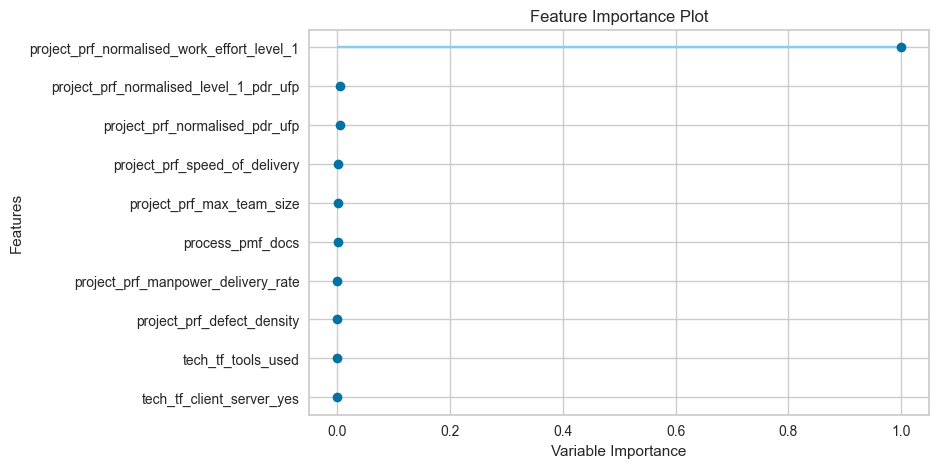

Feature importance plot saved to 'plots/feature_importance.png'


<Figure size 800x550 with 0 Axes>

Cell executed at: 2025-05-17 13:01:00.943973


In [72]:
# PyCaret's built-in feature importance plot
print("\nGenerating PyCaret feature importance plot...")
try:
    # Use plt.savefig() instead of filename parameter
        import matplotlib.pyplot as plt
        
        # Create the feature importance plot
        plot_model(tuned_model, plot='feature', save=False)
        plt.savefig('plots/feature_importance.png')
        print("Feature importance plot saved to 'plots/feature_importance.png'")
except Exception as e:
    print(f"Could not generate feature plot with PyCaret: {e}")
    
    # If PyCaret's plot_model doesn't work, fall back to our custom function
    try:
        importance_df = plot_huber_feature_importance(tuned_model, pycaret_X, pycaret_y, 
                                                    feature_names=pycaret_X.columns.tolist(), 
                                                    method='coefficients')
        print("Top 5 important features:")
        print(importance_df.head(5))
    except Exception as e2:
        print(f"Could not generate feature plot with custom function either: {e2}")


Generating feature importance plot...
Could not generate feature plot: list index out of range

Generating permutation-based feature importance plot...
Could not generate permutation feature plot: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- external_eef_industry_sector
- external_eef_organisation_type
- project_prf_application_type
- tech_tf_server_roles
Feature names seen at fit time, yet now missing:
- external_eef_industry_sector_Missing
- external_eef_industry_sector_banking
- external_eef_industry_sector_communication
- external_eef_industry_sector_education
- external_eef_industry_sector_electronics & computers
- ...



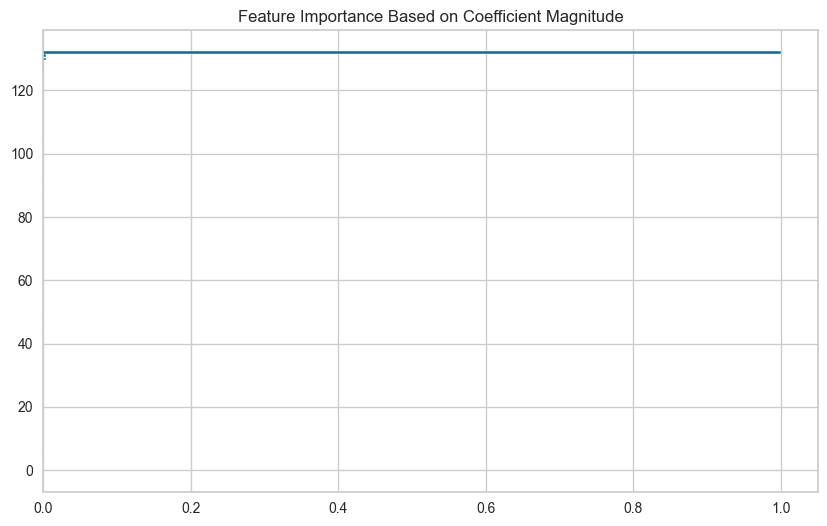

<Figure size 1000x600 with 0 Axes>

Cell executed at: 2025-05-17 13:01:09.691365


In [73]:
# For coefficient-based feature importance
print("\nGenerating feature importance plot...")
try:
    # Use pycaret_X and pycaret_y instead of X and y
    # Get feature names from pycaret_X
    feature_names = pycaret_X.columns.tolist()
    
    importance_df = plot_huber_feature_importance(tuned_model, pycaret_X, pycaret_y, 
                                                feature_names=feature_names, 
                                                method='coefficients')
    print("Top 5 important features:")
    print(importance_df.head(5))
except Exception as e:
    print(f"Could not generate feature plot: {e}")

# For permutation-based feature importance
print("\nGenerating permutation-based feature importance plot...")
try:
    importance_df_perm = plot_huber_feature_importance(tuned_model, pycaret_X, pycaret_y, 
                                                     feature_names=feature_names, 
                                                     method='permutation')
    print("Top 5 important features (permutation):")
    print(importance_df_perm.head(5))
except Exception as e:
    print(f"Could not generate permutation feature plot: {e}")

In [74]:
# Feature importance visualization
print("\nGenerating feature importance plot...")
try:
    if hasattr(model, 'feature_importances_'):
        # Create directory for plots if it doesn't exist
        import os
        os.makedirs('plots', exist_ok=True)
        
        # Use plt.savefig() instead of filename parameter
        import matplotlib.pyplot as plt
        
        # Create the feature importance plot
        plot_model(tuned_model, plot='feature', save=False)
        plt.savefig('plots/feature_importance.png')
        print("Feature importance plot saved to 'plots/feature_importance.png'")
    else:
        print("This model type doesn't support direct feature importance plotting.")
except Exception as e:
    print(f"Could not generate feature plot: {e}")


Generating feature importance plot...
This model type doesn't support direct feature importance plotting.
Cell executed at: 2025-05-17 13:01:20.194216


Cell executed at: 2025-05-17 12:59:02.204284


In [79]:
# SHAP analysis with manual encoding of categorical features
print("\nAttempting SHAP analysis with manually encoded features...")
try:
    import shap
    import os
    from sklearn.preprocessing import OneHotEncoder
    
    # Get all features
    X_for_shap = pycaret_X
    
    # Identify categorical columns
    cat_cols = X_for_shap.select_dtypes(include=['object', 'category']).columns.tolist()
    num_cols = X_for_shap.select_dtypes(include='number').columns.tolist()
    
    if cat_cols:
        print(f"Encoding {len(cat_cols)} categorical columns for SHAP analysis")
        
        # Create and fit one-hot encoder
        # Replace 'sparse' with 'sparse_output'
        encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        encoded_cats = encoder.fit_transform(X_for_shap[cat_cols])
        
        # Create DataFrame with encoded features
        encoded_cols = []
        for i, col in enumerate(cat_cols):
            categories = encoder.categories_[i]
            for cat in categories:
                encoded_cols.append(f"{col}_{cat}")
        
        encoded_df = pd.DataFrame(encoded_cats, columns=encoded_cols, index=X_for_shap.index)
        
        # Combine with numeric features
        X_combined = pd.concat([X_for_shap[num_cols], encoded_df], axis=1)
        print(f"Combined data shape after encoding: {X_combined.shape}")
    else:
        X_combined = X_for_shap
        print("No categorical columns to encode")
    
    # Create directories for output
    os.makedirs('plots', exist_ok=True)
    
    # IMPORTANT: Don't sample the data, use the full dataset
    # This ensures that dimensions match between the model and explanation data
    X_sample = X_combined
    
    # Create SHAP explainer
    print("Creating SHAP explainer with full dataset...")
    explainer = shap.Explainer(tuned_model, X_sample)
    shap_values = explainer(X_sample, check_additivity=False)
    
    # Generate and save SHAP summary plot
    plt.figure(figsize=(12, 10))
    shap.summary_plot(shap_values, X_sample, show=False)
    plt.tight_layout()
    plt.savefig('plots/shap_summary_encoded.png')
    plt.close()
    print("SHAP analysis with encoded features completed and saved as plots/shap_summary_encoded.png")
    
    # Create a bar plot of mean absolute SHAP values for better visual of feature importance
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_sample, plot_type="bar", show=False)
    plt.tight_layout()
    plt.savefig('plots/shap_importance_bar.png')
    plt.close()
    print("SHAP feature importance bar plot saved as plots/shap_importance_bar.png")
    
except Exception as e:
    print(f"SHAP analysis with encoding failed: {e}")


Attempting SHAP analysis with manually encoded features...
Encoding 4 categorical columns for SHAP analysis
Combined data shape after encoding: (85, 98)
Creating SHAP explainer with full dataset...
SHAP analysis with encoding failed: shapes (133,) and (98,) not aligned: 133 (dim 0) != 98 (dim 0)
Cell executed at: 2025-05-17 13:06:12.366022


In [80]:
# SHAP analysis using PyCaret's internal preprocessing
print("\nAttempting SHAP analysis with PyCaret's preprocessing...")
try:
    import shap
    import os
    import numpy as np
    from pycaret.regression import predict_model, get_config
    
    # Create directories for output
    os.makedirs('plots', exist_ok=True)
    
    # Get the preprocessed data that was used for training
    X_transformed = get_config('X_transformed')
    
    if X_transformed is None:
        print("X_transformed not found in PyCaret config, attempting to get transformed data...")
        # Alternative approach: use PyCaret's transform_X function
        from pycaret.regression import transform_X
        X_transformed = transform_X(pycaret_X, tuned_model)
    
    print(f"Transformed feature matrix shape: {X_transformed.shape}")
    
    # For performance reasons, use a subset if the dataset is large
    max_samples = 1000
    if X_transformed.shape[0] > max_samples:
        # Use a fixed random state for reproducibility
        np.random.seed(42)
        sample_indices = np.random.choice(X_transformed.shape[0], max_samples, replace=False)
        X_sample = X_transformed[sample_indices]
        print(f"Using {max_samples} samples for SHAP analysis")
    else:
        X_sample = X_transformed
    
    # Create SHAP explainer
    print("Creating SHAP explainer...")
    
    # Try different SHAP explainer approaches
    try:
        # First approach: standard Explainer
        explainer = shap.Explainer(tuned_model, X_sample)
    except Exception as e1:
        print(f"Standard SHAP explainer failed: {e1}")
        try:
            # Second approach: KernelExplainer
            explainer = shap.KernelExplainer(tuned_model.predict, X_sample)
        except Exception as e2:
            print(f"KernelExplainer failed: {e2}")
            # Third approach: TreeExplainer if applicable
            model_type = str(type(tuned_model)).lower()
            if any(x in model_type for x in ['xgboost', 'lgbm', 'catboost', 'randomforest', 'tree']):
                explainer = shap.TreeExplainer(tuned_model)
            else:
                raise Exception("Could not find compatible SHAP explainer for this model type")
    
    # Calculate SHAP values
    print("Calculating SHAP values...")
    shap_values = explainer(X_sample)
    
    # Generate and save SHAP summary plot
    plt.figure(figsize=(12, 10))
    shap.summary_plot(shap_values, X_sample, show=False)
    plt.tight_layout()
    plt.savefig('plots/shap_summary.png')
    plt.close()
    print("SHAP summary plot saved as plots/shap_summary.png")
    
    # Create a bar plot of mean absolute SHAP values
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_sample, plot_type="bar", show=False)
    plt.tight_layout()
    plt.savefig('plots/shap_importance_bar.png')
    plt.close()
    print("SHAP feature importance bar plot saved as plots/shap_importance_bar.png")
    
except Exception as e:
    print(f"SHAP analysis failed: {e}")
    
    # Alternative approach: Use PyCaret's built-in SHAP plot if available
    print("\nAttempting to use PyCaret's built-in SHAP plot...")
    try:
        from pycaret.regression import plot_model
        plot_model(tuned_model, plot='feature', save=True)
        print("Feature importance plot created using PyCaret's built-in functionality")
    except Exception as e2:
        print(f"PyCaret plot_model also failed: {e2}")
        
        # Last resort: try a simpler feature importance approach
        print("\nFalling back to coefficient-based feature importance...")
        try:
            # Extract coefficients if available
            if hasattr(tuned_model, 'coef_'):
                coefs = tuned_model.coef_
                feature_names = get_config('X').columns
                
                # Create a DataFrame of feature importances
                importance_df = pd.DataFrame({
                    'Feature': feature_names,
                    'Importance': np.abs(coefs)
                }).sort_values('Importance', ascending=False)
                
                # Plot feature importances
                plt.figure(figsize=(10, 8))
                plt.barh(importance_df['Feature'][:20], importance_df['Importance'][:20])
                plt.xlabel('Absolute Coefficient Value')
                plt.title('Feature Importance Based on Coefficients')
                plt.tight_layout()
                plt.savefig('plots/coefficient_importance.png')
                plt.close()
                print("Coefficient-based feature importance plot saved as plots/coefficient_importance.png")
                print("\nTop 10 important features:")
                print(importance_df.head(10))
            else:
                print("Model does not have coefficients, cannot create feature importance plot")
        except Exception as e3:
            print(f"All feature importance methods failed: {e3}")


Attempting SHAP analysis with PyCaret's preprocessing...
Transformed feature matrix shape: (85, 133)
Creating SHAP explainer...
Calculating SHAP values...
SHAP analysis failed: loop of ufunc does not support argument 0 of type float which has no callable rint method

Attempting to use PyCaret's built-in SHAP plot...


Feature importance plot created using PyCaret's built-in functionality
Cell executed at: 2025-05-17 13:07:34.080846


In [82]:
# SHAP analysis with proper data type handling
print("\nAttempting SHAP analysis with improved data handling...")
try:
    import shap
    import os
    import numpy as np
    import pandas as pd
    from pycaret.regression import get_config
    import matplotlib.pyplot as plt
    
    # Create directories for output
    os.makedirs('plots', exist_ok=True)
    
    # Get the transformed data
    X_transformed = get_config('X_transformed')
    print(f"Transformed feature matrix shape: {X_transformed.shape}")
    
    # Convert data to float64 to avoid data type issues
    X_transformed_float = X_transformed.astype(np.float64)
    print("Data converted to float64 type to avoid SHAP errors")
    
    # Get feature names if possible
    try:
        feature_names = get_config('X').columns.tolist()
    except:
        feature_names = [f"Feature_{i}" for i in range(X_transformed.shape[1])]
    
    # Determine the right SHAP explainer based on model type
    model_type = str(type(tuned_model)).lower()
    print(f"Model type: {type(tuned_model).__name__}")
    
    if any(x in model_type for x in ['tree', 'forest', 'xgboost', 'lgbm', 'catboost']):
        print("Using TreeExplainer for tree-based model")
        explainer = shap.TreeExplainer(tuned_model)
        shap_values = explainer(X_transformed_float)
    elif any(x in model_type for x in ['linear', 'logistic', 'ridge', 'lasso', 'huber']):
        print("Using LinearExplainer for linear model")
        explainer = shap.LinearExplainer(tuned_model, X_transformed_float)
        shap_values = explainer(X_transformed_float)
    else:
        print("Using KernelExplainer as fallback (this might be slow)")
        # For more complex models, use KernelExplainer with a subset of data for speed
        sample_size = min(50, X_transformed_float.shape[0])
        sample_indices = np.random.choice(X_transformed_float.shape[0], sample_size, replace=False)
        X_sample = X_transformed_float[sample_indices]
        
        # Create a prediction function that returns a numpy array
        def model_predict(X):
            return tuned_model.predict(X)
        
        explainer = shap.KernelExplainer(model_predict, X_sample)
        shap_values = explainer.shap_values(X_sample)
    
    # Generate and save SHAP summary plot
    plt.figure(figsize=(12, 10))
    if isinstance(shap_values, np.ndarray):
        shap.summary_plot(shap_values, X_transformed_float if not 'X_sample' in locals() else X_sample, 
                          feature_names=feature_names, show=False)
    else:
        shap.summary_plot(shap_values, show=False)
    plt.tight_layout()
    plt.savefig('plots/shap_summary.png')
    plt.close()
    print("SHAP summary plot saved as plots/shap_summary.png")
    
    # Create a bar plot of mean absolute SHAP values
    plt.figure(figsize=(12, 8))
    if isinstance(shap_values, np.ndarray):
        shap.summary_plot(shap_values, X_transformed_float if not 'X_sample' in locals() else X_sample, 
                          feature_names=feature_names, plot_type="bar", show=False)
    else:
        shap.summary_plot(shap_values, plot_type="bar", show=False)
    plt.tight_layout()
    plt.savefig('plots/shap_importance_bar.png')
    plt.close()
    print("SHAP feature importance bar plot saved as plots/shap_importance_bar.png")
    
    # Try to create waterfall plot for first instance
    try:
        plt.figure(figsize=(10, 8))
        if isinstance(shap_values, np.ndarray):
            shap.plots.waterfall(shap_values[0], show=False)
        else:
            shap.plots.waterfall(shap_values[0], show=False)
        plt.tight_layout()
        plt.savefig('plots/shap_waterfall.png')
        plt.close()
        print("SHAP waterfall plot saved as plots/shap_waterfall.png")
    except Exception as e:
        print(f"Could not create waterfall plot: {e}")
    
except Exception as e:
    print(f"SHAP analysis failed: {e}")
    
    # Try PyCaret's SHAP plot as fallback
    print("\nTrying PyCaret's built-in SHAP plot...")
    try:
        from pycaret.regression import plot_model
        plot_model(tuned_model, plot='shap', save=True)
        print("SHAP plot created using PyCaret's built-in functionality")
    except Exception as e2:
        print(f"PyCaret's SHAP plot also failed: {e2}")
        print("\nRecommendation: Rely on the feature importance plot that was successfully created earlier")


Attempting SHAP analysis with improved data handling...
Transformed feature matrix shape: (85, 133)
Data converted to float64 type to avoid SHAP errors
Model type: HuberRegressor
Using LinearExplainer for linear model
SHAP summary plot saved as plots/shap_summary.png
SHAP feature importance bar plot saved as plots/shap_importance_bar.png
SHAP waterfall plot saved as plots/shap_waterfall.png
Cell executed at: 2025-05-17 13:12:40.446443


In [76]:
# Extract feature importance directly (if available)
print("\nExtracting direct feature importance...")
try:
    if hasattr(tuned_model, 'feature_importances_'):
        # Make sure the feature names and importance values match in length
        feature_names = pycaret_X.columns
        importances = tuned_model.feature_importances_
        
        # Ensure lengths match
        if len(feature_names) != len(importances):
            print(f"Warning: Length mismatch - {len(feature_names)} features vs {len(importances)} importance values")
            # Use only the matching length
            min_length = min(len(feature_names), len(importances))
            feature_names = feature_names[:min_length]
            importances = importances[:min_length]
        
        # Create DataFrame with matching lengths
        fi = pd.DataFrame({
            'feature': feature_names,
            'importance': importances
        })
        
        # Sort by importance value
        fi = fi.sort_values('importance', ascending=False)
        print(fi.head(15))  # Show top 15 features
        
        # Save to CSV
        fi.to_csv('feature_importance.csv', index=False)
        print("Feature importance saved to 'feature_importance.csv'")
    else:
        print("Feature importance attribute not available for this model")
except Exception as e:
    print(f"Failed to extract feature importance: {e}")


Extracting direct feature importance...
Feature importance attribute not available for this model
Cell executed at: 2025-05-17 13:02:12.135929
